# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters

In [3]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [4]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [5]:
params = vaep.nb.get_params(args, globals=globals())
params

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


{'folder_data': '',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'folder_experiment': 'runs/alzheimer_study',
 'model_key': 'QRILC',
 'target': 'AD',
 'sample_id_col': 'Sample ID',
 'cutoff_target': 0.5,
 'file_format': 'csv',
 'out_folder': 'diff_analysis',
 'fn_qc_samples': '',
 'baseline': 'PI',
 'template_pred': 'pred_real_na_{}.csv'}

In [6]:
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
args

root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

In [7]:
files_out = dict()

## Load target

In [8]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### Measured data

In [9]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_105  Q99574           18.753
Sample_202  P15151-2         15.644
Sample_119  P49257           16.235
Sample_088  P05362           14.581
Sample_146  Q9ULB4           13.917
Name: intensity, dtype: float64

Get overlap between independent features and target

### Load ALD data or create

In [10]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [11]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load semi-supervised model imputations

In [12]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups
Sample_013  P20382           12.446
            P69905           11.758
Sample_138  P04430           10.288
Name: intensity, dtype: float64

In [13]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.367
            A0A075B6Q5                 12.104
            A0A075B6R2                 12.507
            A0A075B6S5                 13.626
            A0A087WSY4                 13.471
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.640
            Q9UI40;Q9UI40-2            12.844
            Q9UIW2                     12.084
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.727
            Q9UP79                     13.120
Name: intensity, Length: 46401, dtype: float64

# Model predictions
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
3. newly available feat only: the subset of features available from the
self supervised deep learning model which were newly retained using the
new approach

In [14]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,11.693,15.050,16.842,19.863,14.198,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.727,19.067,...,15.528,15.576,12.483,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.259,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.789,17.705,17.039,13.914,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.789,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.631,15.345,17.084,18.708,14.249,19.433,9.573,10.235
Sample_207,15.739,16.877,15.469,16.898,12.326,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [15]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.367,...,16.012,15.178,13.103,15.050,16.842,19.863,12.911,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.362,19.067,16.188,...,15.528,15.576,12.908,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,14.032,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.549,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.699,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.879,15.345,17.084,18.708,14.249,19.433,11.441,13.331
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [16]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification


In [17]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Best number of parameters by CV

In [18]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 361.58it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.27it/s]

100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.65it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.85it/s]

100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.30it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.35it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.33it/s]

100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.33it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.44it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.00it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.63it/s]

100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.96it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.92it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.01it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.06it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.41it/s]

100%|██████████| 7/7 [00:02<00:00,  2.17it/s]

100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.42it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.59it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.88it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.37it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.74it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.46it/s]

100%|██████████| 8/8 [00:02<00:00,  2.14it/s]

100%|██████████| 8/8 [00:02<00:00,  2.75it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.54it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.85it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.55it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.12it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.94it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.95it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.93it/s]

100%|██████████| 9/9 [00:04<00:00,  2.07it/s]

100%|██████████| 9/9 [00:04<00:00,  2.19it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.17it/s]

 30%|███       | 3/10 [00:00<00:01,  4.33it/s]

 40%|████      | 4/10 [00:01<00:01,  3.51it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.09it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.71it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.35it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.49it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.58it/s]

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]

100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.30it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.58it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.01it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.21it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.87it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.30it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.10it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  2.00it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.88it/s]

100%|██████████| 11/11 [00:04<00:00,  1.87it/s]

100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.86it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.70it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.49it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.42it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.10it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.98it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.02it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.90it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.09it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.13it/s]

100%|██████████| 12/12 [00:05<00:00,  2.36it/s]

100%|██████████| 12/12 [00:05<00:00,  2.26it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.78it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.28it/s]

 31%|███       | 4/13 [00:01<00:02,  3.27it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.10it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.08it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.63it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.21it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.19it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.14it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.37it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.55it/s]

100%|██████████| 13/13 [00:04<00:00,  2.55it/s]

100%|██████████| 13/13 [00:04<00:00,  2.63it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.10it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.74it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.31it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.17it/s]

 43%|████▎     | 6/14 [00:01<00:03,  2.57it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.27it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.17it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.19it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.36it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.46it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.50it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.53it/s]

100%|██████████| 14/14 [00:05<00:00,  2.67it/s]

100%|██████████| 14/14 [00:05<00:00,  2.64it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.73it/s]

 20%|██        | 3/15 [00:00<00:02,  4.45it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.88it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.57it/s]

 40%|████      | 6/15 [00:01<00:02,  3.13it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.82it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.52it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.31it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.38it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.24it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.07it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.99it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.00it/s]

100%|██████████| 15/15 [00:06<00:00,  2.00it/s]

100%|██████████| 15/15 [00:06<00:00,  2.46it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.008 0.007      0.090 0.039          0.823 0.276       0.136   
2             0.006 0.004      0.080 0.026          0.702 0.091       0.605   
3             0.005 0.004      0.063 0.025          0.693 0.094       0.601   
4             0.005 0.004      0.076 0.034          0.746 0.089       0.640   
5             0.006 0.004      0.073 0.026          0.713 0.080       0.681   
6             0.005 0.004      0.057 0.021          0.708 0.087       0.673   
7             0.005 0.004      0.069 0.028          0.796 0.089       0.804   
8             0.007 0.006      0.071 0.028          0.802 0.081       0.820   
9             0.006 0.004      0.070 0.026          0.801 0.077       0.821   
10            0.006 0.005      0.068 0.028          0.794 0.080       0.836   
11            0.005 0.004      0.059 0.025          0.798 0.088       0.820   
12            0.004 0.001      0.056 0.016          0.798 0.088       0.820   
13            0.008 0.006      0.078 0.030          0.800 0.073       0.823   
14            0.007 0.006      0.075 0.027          0.828 0.081       0.837   
15            0.006 0.005      0.066 0.027          0.817 0.091       0.824   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.225 0.128                  0.560 0.043        0.856   
2          0.106   0.644 0.080                  0.707 0.060        0.788   
3          0.105   0.638 0.081                  0.701 0.060        0.782   
4          0.109   0.684 0.083                  0.739 0.063        0.807   
5          0.108   0.691 0.075                  0.739 0.058        0.811   
6          0.109   0.684 0.077                  0.733 0.061        0.810   
7          0.108   0.794 0.071                  0.824 0.061        0.894   
8          0.096   0.807 0.068                  0.835 0.058        0.909   
9          0.096   0.807 0.065                  0.835 0.057        0.908   
10         0.093   0.811 0.068                  0.837 0.060        0.906   
11         0.102   0.805 0.076                  0.833 0.066        0.905   
12         0.104   0.805 0.076                  0.833 0.066        0.902   
13         0.095   0.807 0.064                  0.835 0.055        0.905   
14         0.096   0.828 0.065                  0.853 0.056        0.914   
15         0.094   0.817 0.073                  0.843 0.064        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.825 0.087        210.000 0.000  
2          0.065                  0.762 0.084        210.000 0.000  
3          0.065                  0.756 0.084        210.000 0.000  
4          0.060                  0.773 0.083        210.000 0.000  
5          0.057                  0.771 0.083        210.000 0.000  
6          0.059                  0.772 0.085        210.000 0.000  
7          0.048                  0.868 0.056        210.000 0.000  
8          0.048                  0.895 0.052        210.000 0.000  
9          0.048                  0.894 0.053        210.000 0.000  
10         0.049                  0.895 0.051        210.000 0.000  
11         0.050                  0.892 0.051        210.000 0.000  
12         0.051                  0.889 0.053        210.000 0.000  
13         0.050                  0.891 0.056        210.000 0.000  
14         0.047                  0.901 0.052        210.000 0.000  
15         0.048                  0.902 0.052 

In [19]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 446.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.78it/s]

100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.39it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.39it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.24it/s]

 80%|████████  | 4/5 [00:01<00:00,  1.91it/s]

100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.05it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.66it/s]

 67%|██████▋   | 4/6 [00:01<00:01,  1.95it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.67it/s]

100%|██████████| 6/6 [00:03<00:00,  1.56it/s]

100%|██████████| 6/6 [00:03<00:00,  1.85it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.78it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.77it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.55it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.23it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.94it/s]

100%|██████████| 7/7 [00:02<00:00,  2.04it/s]

100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.49it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.50it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.14it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.87it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.76it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.81it/s]

100%|██████████| 8/8 [00:03<00:00,  1.87it/s]

100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.21it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.28it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.54it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.19it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.04it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.12it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.26it/s]

100%|██████████| 9/9 [00:03<00:00,  2.16it/s]

100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.32it/s]

 30%|███       | 3/10 [00:00<00:02,  2.96it/s]

 40%|████      | 4/10 [00:01<00:02,  2.53it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.35it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.13it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.18it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.13it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.09it/s]

100%|██████████| 10/10 [00:04<00:00,  2.10it/s]

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.62it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.70it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.22it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.94it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.95it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.98it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.11it/s]

 82%|████████▏ | 9/11 [00:04<00:00,  2.20it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.21it/s]

100%|██████████| 11/11 [00:04<00:00,  2.25it/s]

100%|██████████| 11/11 [00:04<00:00,  2.24it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.65it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.48it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.05it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.98it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.09it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.05it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.20it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.33it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.21it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.35it/s]

100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

100%|██████████| 12/12 [00:05<00:00,  2.25it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.44it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.20it/s]

 31%|███       | 4/13 [00:01<00:04,  2.12it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.06it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.13it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.20it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.23it/s]

 69%|██████▉   | 9/13 [00:04<00:01,  2.26it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.34it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.38it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.32it/s]

100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

100%|██████████| 13/13 [00:05<00:00,  2.29it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.51it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.46it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.03it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.99it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.14it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.22it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.25it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.33it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.34it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.14it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.18it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.16it/s]

100%|██████████| 14/14 [00:06<00:00,  2.05it/s]

100%|██████████| 14/14 [00:06<00:00,  2.19it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.90it/s]

 20%|██        | 3/15 [00:01<00:04,  2.78it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.16it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.89it/s]

 40%|████      | 6/15 [00:02<00:04,  1.94it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.10it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.24it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.90it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.85it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.80it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.75it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.73it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.67it/s]

100%|██████████| 15/15 [00:07<00:00,  1.62it/s]

100%|██████████| 15/15 [00:07<00:00,  1.89it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.085 0.027          0.826 0.274       0.143   
2             0.005 0.003      0.068 0.028          0.772 0.084       0.736   
3             0.004 0.002      0.060 0.025          0.768 0.082       0.734   
4             0.006 0.005      0.074 0.026          0.780 0.089       0.745   
5             0.004 0.003      0.053 0.032          0.798 0.088       0.768   
6             0.005 0.004      0.065 0.025          0.797 0.086       0.767   
7             0.005 0.003      0.070 0.026          0.798 0.086       0.757   
8             0.004 0.003      0.052 0.018          0.806 0.086       0.763   
9             0.005 0.003      0.054 0.015          0.799 0.090       0.765   
10            0.004 0.002      0.057 0.019          0.800 0.087       0.770   
11            0.005 0.003      0.056 0.016          0.839 0.078       0.811   
12            0.004 0.002      0.054 0.014          0.845 0.078       0.812   
13            0.005 0.004      0.053 0.015          0.855 0.076       0.818   
14            0.004 0.002      0.048 0.017          0.849 0.083       0.817   
15            0.005 0.003      0.060 0.021          0.848 0.081       0.815   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.235 0.127                  0.563 0.043        0.850   
2          0.093   0.750 0.071                  0.787 0.060        0.872   
3          0.087   0.747 0.067                  0.784 0.056        0.867   
4          0.082   0.758 0.064                  0.794 0.054        0.875   
5          0.089   0.778 0.063                  0.811 0.053        0.894   
6          0.096   0.777 0.069                  0.810 0.058        0.896   
7          0.092   0.772 0.066                  0.806 0.055        0.897   
8          0.094   0.779 0.065                  0.811 0.056        0.894   
9          0.098   0.776 0.067                  0.809 0.056        0.906   
10         0.098   0.779 0.066                  0.812 0.055        0.905   
11         0.098   0.821 0.068                  0.847 0.058        0.914   
12         0.092   0.824 0.067                  0.850 0.057        0.914   
13         0.086   0.832 0.056                  0.856 0.047        0.921   
14         0.085   0.829 0.061                  0.853 0.051        0.919   
15         0.094   0.827 0.067                  0.853 0.056        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.824 0.088        210.000 0.000  
2          0.047                  0.845 0.059        210.000 0.000  
3          0.049                  0.839 0.063        210.000 0.000  
4          0.047                  0.846 0.065        210.000 0.000  
5          0.046                  0.879 0.053        210.000 0.000  
6          0.044                  0.883 0.049        210.000 0.000  
7          0.044                  0.882 0.050        210.000 0.000  
8          0.046                  0.880 0.052        210.000 0.000  
9          0.044                  0.889 0.051        210.000 0.000  
10         0.044                  0.887 0.052        210.000 0.000  
11         0.043                  0.903 0.045        210.000 0.000  
12         0.044                  0.902 0.047        210.000 0.000  
13         0.041                  0.910 0.044        210.000 0.000  
14         0.044                  0.908 0.047        210.000 0.000  
15         0.044                  0.908 0.046 

In [20]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 936.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 23.87it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.38it/s]

100%|██████████| 3/3 [00:00<00:00, 15.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 16.38it/s]

100%|██████████| 4/4 [00:00<00:00, 10.34it/s]

100%|██████████| 4/4 [00:00<00:00, 10.41it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.15it/s]

100%|██████████| 5/5 [00:00<00:00, 12.66it/s]

100%|██████████| 5/5 [00:00<00:00, 13.07it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.65it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.19it/s]

100%|██████████| 6/6 [00:00<00:00, 14.05it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 19.53it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 12.18it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 11.02it/s]

100%|██████████| 7/7 [00:00<00:00, 11.81it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.22it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.51it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 14.31it/s]

100%|██████████| 8/8 [00:00<00:00, 14.63it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 18.41it/s]

 44%|████▍     | 4/9 [00:00<00:00, 15.13it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 11.86it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 11.50it/s]

100%|██████████| 9/9 [00:00<00:00, 11.62it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 19.48it/s]

 40%|████      | 4/10 [00:00<00:00, 13.56it/s]

 60%|██████    | 6/10 [00:00<00:00, 11.10it/s]

 80%|████████  | 8/10 [00:00<00:00, 10.79it/s]

100%|██████████| 10/10 [00:00<00:00,  9.98it/s]

100%|██████████| 10/10 [00:00<00:00, 10.70it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 13.68it/s]

 36%|███▋      | 4/11 [00:00<00:00, 10.54it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.26it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  9.88it/s]

 91%|█████████ | 10/11 [00:00<00:00,  9.69it/s]

100%|██████████| 11/11 [00:01<00:00,  9.64it/s]

100%|██████████| 11/11 [00:01<00:00,  9.93it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 16.39it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.85it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.38it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.43it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 10.84it/s]

100%|██████████| 12/12 [00:00<00:00, 12.29it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 19.49it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.55it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.66it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.83it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.01it/s]

100%|██████████| 13/13 [00:01<00:00, 10.94it/s]

100%|██████████| 13/13 [00:01<00:00, 12.02it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.49it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.99it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.07it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 10.73it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 10.86it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.57it/s]

100%|██████████| 14/14 [00:01<00:00, 11.27it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 17.93it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.27it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.71it/s]

 60%|██████    | 9/15 [00:00<00:00, 10.55it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  9.71it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.56it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.42it/s]

100%|██████████| 15/15 [00:01<00:00,  9.07it/s]

100%|██████████| 15/15 [00:01<00:00, 10.19it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.072 0.023          0.020 0.141       0.001   
2             0.005 0.004      0.073 0.033          0.593 0.136       0.327   
3             0.006 0.005      0.066 0.026          0.570 0.138       0.320   
4             0.005 0.004      0.068 0.028          0.548 0.134       0.331   
5             0.007 0.006      0.067 0.025          0.603 0.126       0.443   
6             0.005 0.005      0.056 0.018          0.594 0.132       0.416   
7             0.004 0.005      0.047 0.020          0.570 0.110       0.426   
8             0.005 0.003      0.063 0.022          0.587 0.107       0.472   
9             0.005 0.003      0.050 0.014          0.575 0.095       0.470   
10            0.005 0.003      0.064 0.026          0.573 0.090       0.470   
11            0.007 0.005      0.084 0.025          0.561 0.095       0.454   
12            0.005 0.003      0.068 0.025          0.595 0.096       0.495   
13            0.009 0.007      0.090 0.032          0.591 0.102       0.494   
14            0.006 0.005      0.069 0.025          0.579 0.105       0.495   
15            0.006 0.004      0.067 0.026          0.577 0.093       0.541   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.501 0.004        0.734   
2          0.102   0.411 0.098                  0.578 0.053        0.668   
3          0.098   0.400 0.094                  0.568 0.056        0.656   
4          0.102   0.404 0.096                  0.563 0.056        0.641   
5          0.113   0.505 0.106                  0.613 0.076        0.664   
6          0.120   0.481 0.114                  0.602 0.077        0.653   
7          0.092   0.481 0.085                  0.592 0.066        0.650   
8          0.106   0.517 0.092                  0.613 0.067        0.668   
9          0.095   0.513 0.084                  0.607 0.062        0.666   
10         0.110   0.511 0.091                  0.607 0.066        0.668   
11         0.111   0.498 0.098                  0.599 0.071        0.661   
12         0.108   0.536 0.093                  0.624 0.068        0.672   
13         0.109   0.534 0.098                  0.622 0.074        0.666   
14         0.109   0.529 0.096                  0.615 0.075        0.664   
15         0.111   0.554 0.092                  0.625 0.074        0.677   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.654 0.079        210.000 0.000  
2          0.071                  0.583 0.081        210.000 0.000  
3          0.073                  0.565 0.079        210.000 0.000  
4          0.073                  0.559 0.084        210.000 0.000  
5          0.074                  0.601 0.085        210.000 0.000  
6          0.079                  0.596 0.088        210.000 0.000  
7          0.084                  0.595 0.090        210.000 0.000  
8          0.076                  0.603 0.084        210.000 0.000  
9          0.074                  0.596 0.083        210.000 0.000  
10         0.080                  0.585 0.084        210.000 0.000  
11         0.075                  0.592 0.080        210.000 0.000  
12         0.078                  0.633 0.084        210.000 0.000  
13         0.078                  0.628 0.085        210.000 0.000  
14         0.077                  0.619 0.084        210.000 0.000  
15         0.075                  0.646 0.084 

In [21]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,1,1,13
score_time,1,1,13
test_precision,14,13,5
test_recall,14,13,15
test_f1,14,13,15
test_balanced_accuracy,14,13,15
test_roc_auc,15,13,1
test_average_precision,15,13,1
n_observations,1,1,1


## Train, test split

In [22]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

In [23]:
njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


In [24]:
y_train.value_counts()

AD   
False   98
True    70
Name: count, dtype: int64

## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

In [25]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:04,  2.61it/s]

 23%|██▎       | 3/13 [00:01<00:05,  1.97it/s]

 31%|███       | 4/13 [00:01<00:04,  1.95it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.91it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.99it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.83it/s]

 62%|██████▏   | 8/13 [00:04<00:02,  1.74it/s]

 69%|██████▉   | 9/13 [00:05<00:02,  1.59it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.64it/s]

 85%|████████▍ | 11/13 [00:06<00:01,  1.73it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.68it/s]

100%|██████████| 13/13 [00:07<00:00,  1.79it/s]

100%|██████████| 13/13 [00:07<00:00,  1.81it/s]

In [26]:
# all(results_model_full.test.roc.tpr
#     ==
#     vaep.sklearn.Results.from_pickle(fname).test.roc.tpr)

In [27]:
splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 907.86it/s]

In [28]:
splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.79it/s]

 20%|██        | 3/15 [00:01<00:04,  2.66it/s]

 27%|██▋       | 4/15 [00:01<00:05,  1.97it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.74it/s]

 40%|████      | 6/15 [00:03<00:05,  1.57it/s]

 47%|████▋     | 7/15 [00:03<00:05,  1.57it/s]

 53%|█████▎    | 8/15 [00:04<00:04,  1.69it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.72it/s]

 67%|██████▋   | 10/15 [00:05<00:02,  1.85it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.93it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.98it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.99it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  2.13it/s]

100%|██████████| 15/15 [00:07<00:00,  2.11it/s]

100%|██████████| 15/15 [00:07<00:00,  1.96it/s]

### ROC-AUC

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


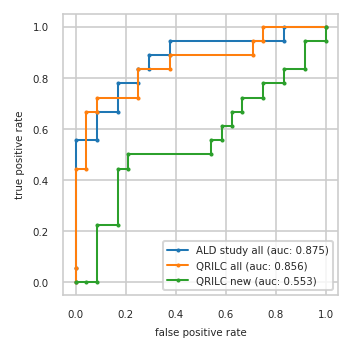

In [29]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [30]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.556     0.000 0.444     0.083 0.000
3          0.083 0.556     0.042 0.444     0.083 0.222
4          0.083 0.667     0.042 0.667     0.167 0.222
5          0.167 0.667     0.083 0.667     0.167 0.444
6          0.167 0.778     0.083 0.722     0.208 0.444
7          0.250 0.778     0.250 0.722     0.208 0.500
8          0.250 0.833     0.250 0.833     0.542 0.500
9          0.292 0.833     0.375 0.833     0.542 0.556
10         0.292 0.889     0.375 0.889     0.583 0.556
11         0.375 0.889     0.708 0.889     0.583 0.611
12         0.375 0.944     0.708 0.944     0.625 0.611
13         0.833 0.944     0.750 0.944     0.625 0.667
14         0.833 1.000     0.750 1.000     0.667 0.667
15         1.000 1.000     1.000 1.000     0.667 0.722
16           NaN   NaN       NaN   NaN     0.750 0.722
17           NaN   NaN       NaN   NaN     0.750 0.778
18           NaN   NaN       NaN   NaN     0.833 0.778
19           NaN   NaN       NaN   NaN     0.833 0.833
20           NaN   NaN       NaN   NaN     0.917 0.833
21           NaN   NaN       NaN   NaN     0.917 0.944
22           NaN   NaN       NaN   NaN     1.000 0.944
23           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected

In [31]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,B0QYF8;P02144,B1AN99;P35030;P35030-2;P35030-3;P35030-4;P35030-5,None
2,P02766,P10636-2;P10636-6,None
3,B1AHL2;P23142-4,Q6EMK4,None
4,P61981,P61981,None
5,P14174,P04075,None
6,P04075,P14174,None
7,Q9Y2T3;Q9Y2T3-3,E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2,None
8,P00338;P00338-3,P63104,None


### Precision-Recall plot

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


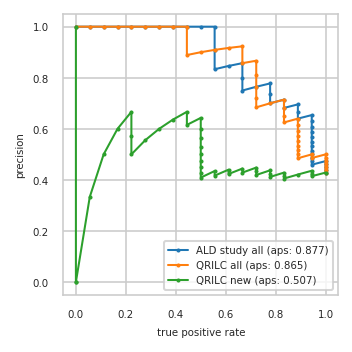

In [32]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [33]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.415 0.944
2          0.450 1.000     0.450 1.000     0.425 0.944
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.421 0.889
5          0.459 0.944     0.486 1.000     0.405 0.833
6          0.472 0.944     0.500 1.000     0.417 0.833
7          0.486 0.944     0.486 0.944     0.429 0.833
8          0.500 0.944     0.500 0.944     0.412 0.778
9          0.515 0.944     0.485 0.889     0.424 0.778
10         0.531 0.944     0.500 0.889     0.438 0.778
11         0.548 0.944     0.516 0.889     0.419 0.722
12         0.567 0.944     0.533 0.889     0.433 0.722
13         0.586 0.944     0.552 0.889     0.448 0.722
14         0.607 0.944     0.571 0.889     0.429 0.667
15         0.630 0.944     0.593 0.889     0.444 0.667
16         0.654 0.944     0.615 0.889     0.423 0.611
17         0.640 0.889     0.640 0.889     0.440 0.611
18         0.667 0.889     0.625 0.833     0.417 0.556
19         0.696 0.889     0.652 0.833     0.435 0.556
20         0.682 0.833     0.682 0.833     0.409 0.500
21         0.714 0.833     0.714 0.833     0.429 0.500
22         0.700 0.778     0.700 0.778     0.450 0.500
23         0.737 0.778     0.684 0.722     0.474 0.500
24         0.778 0.778     0.722 0.722     0.500 0.500
25         0.765 0.722     0.765 0.722     0.529 0.500
26         0.750 0.667     0.812 0.722     0.562 0.500
27         0.800 0.667     0.867 0.722     0.600 0.500
28         0.857 0.667     0.857 0.667     0.643 0.500
29         0.846 0.611     0.923 0.667     0.615 0.444
30         0.833 0.556     0.917 0.611     0.667 0.444
31         0.909 0.556     0.909 0.556     0.636 0.389
32         1.000 0.556     0.900 0.500     0.600 0.333
33         1.000 0.500     0.889 0.444     0.556 0.278
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


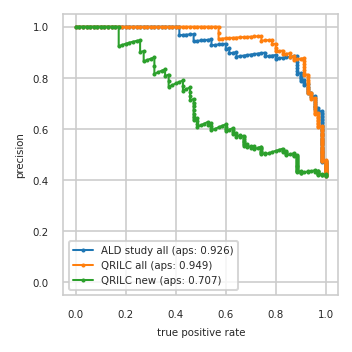

In [34]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


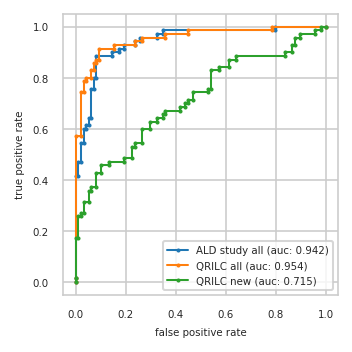

In [35]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Options:
- F1 results for test data for best cutoff on training data?
  (select best cutoff of training data, evaluate on test data)
- plot X_train PCA/UMAP, map X_test

In [36]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}